# Evaluation Notebook - LC-PFN vs. Parametric Models
### Comparative experiment: Flat vs non-Flat, Monotone & Convex vs non-Monotone & Convex, Peaking vs non-Peaking, Dipping vs non-Dipping

In [33]:
import h5py
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from math import pi
import matplotlib.patheffects as path_effects
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import lcpfn
from lcpfn import bar_distribution, encoders, train, utils

In [34]:
### hyperparameter
OPENML_ID = {0: '3', 1: '6', 2: '11', 3: '12', 4: '13', 5: '14', 6: '15', 7: '16', 8: '18', 9: '21', 10: '22', 11: '23', 12: '24', 13: '26', 14: '28', 15: '29', 16: '30', 17: '31', 18: '32', 19: '36', 20: '37', 21: '38', 22: '44', 23: '46', 24: '50', 25: '54', 26: '55', 27: '57', 28: '60', 29: '61', 30: '151', 31: '179', 32: '180', 33: '181', 34: '182', 35: '184', 36: '185', 37: '188', 38: '201', 39: '273', 40: '293', 41: '299', 42: '300', 43: '307', 44: '336', 45: '346', 46: '351', 47: '354', 48: '357', 49: '380', 50: '389', 51: '390', 52: '391', 53: '392', 54: '393', 55: '395', 56: '396', 57: '398', 58: '399', 59: '401', 60: '446', 61: '458', 62: '469', 63: '554', 64: '679', 65: '715', 66: '718', 67: '720', 68: '722', 69: '723', 70: '727', 71: '728', 72: '734', 73: '735', 74: '737', 75: '740', 76: '741', 77: '743', 78: '751', 79: '752', 80: '761', 81: '772', 82: '797', 83: '799', 84: '803', 85: '806', 86: '807', 87: '813', 88: '816', 89: '819', 90: '821', 91: '822', 92: '823', 93: '833', 94: '837', 95: '843', 96: '845', 97: '846', 98: '847', 99: '849', 100: '866', 101: '871', 102: '881', 103: '897', 104: '901', 105: '903', 106: '904', 107: '910', 108: '912', 109: '913', 110: '914', 111: '917', 112: '923', 113: '930', 114: '934', 115: '953', 116: '958', 117: '959', 118: '962', 119: '966', 120: '971', 121: '976', 122: '977', 123: '978', 124: '979', 125: '980', 126: '991', 127: '993', 128: '995', 129: '1000', 130: '1002', 131: '1018', 132: '1019', 133: '1020', 134: '1021', 135: '1036', 136: '1040', 137: '1041', 138: '1042', 139: '1049', 140: '1050', 141: '1053', 142: '1056', 143: '1063', 144: '1067', 145: '1068', 146: '1069', 147: '1083', 148: '1084', 149: '1085', 150: '1086', 151: '1087', 152: '1088', 153: '1116', 154: '1119', 155: '1120', 156: '1128', 157: '1130', 158: '1134', 159: '1138', 160: '1139', 161: '1142', 162: '1146', 163: '1161', 164: '1166', 165: '1216', 166: '1233', 167: '1235', 168: '1236', 169: '1441', 170: '1448', 171: '1450', 172: '1457', 173: '1461', 174: '1462', 175: '1464', 176: '1465', 177: '1468', 178: '1475', 179: '1477', 180: '1478', 181: '1479', 182: '1480', 183: '1483', 184: '1485', 185: '1486', 186: '1487', 187: '1488', 188: '1489', 189: '1494', 190: '1497', 191: '1499', 192: '1501', 193: '1503', 194: '1509', 195: '1510', 196: '1515', 197: '1566', 198: '1567', 199: '1575', 200: '1590', 201: '1592', 202: '1597', 203: '4134', 204: '4135', 205: '4137', 206: '4534', 207: '4538', 208: '4541', 209: '6332', 210: '23381', 211: '23512', 212: '23517', 213: '40498', 214: '40499', 215: '40664', 216: '40668', 217: '40670', 218: '40672', 219: '40677', 220: '40685', 221: '40687', 222: '40701', 223: '40713', 224: '40900', 225: '40910', 226: '40923', 227: '40927', 228: '40966', 229: '40971', 230: '40975', 231: '40978', 232: '40979', 233: '40981', 234: '40982', 235: '40983', 236: '40984', 237: '40994', 238: '40996', 239: '41027', 240: '41142', 241: '41143', 242: '41144', 243: '41145', 244: '41146', 245: '41150', 246: '41156', 247: '41157', 248: '41158', 249: '41159', 250: '41161', 251: '41163', 252: '41164', 253: '41165', 254: '41166', 255: '41167', 256: '41168', 257: '41169', 258: '41228', 259: '41972', 260: '42734', 261: '42742', 262: '42769', 263: '42809', 264: '42810'}
LEARNER_ZOO = {0: 'SVC_linear', 1: 'SVC_poly', 2: 'SVC_rbf', 3: 'SVC_sigmoid', 4: 'Decision Tree', 5: 'ExtraTree', 6: 'LogisticRegression', 7: 'PassiveAggressive', 8: 'Perceptron', 9: 'RidgeClassifier', 10: 'SGDClassifier', 11: 'MLP', 12: 'LDA', 13: 'QDA', 14: 'BernoulliNB', 15: 'MultinomialNB', 16: 'ComplementNB', 17: 'GaussianNB', 18: 'KNN', 19: 'NearestCentroid', 20: 'ens.ExtraTrees', 21: 'ens.RandomForest', 22: 'ens.GradientBoosting', 23: 'DummyClassifier'}
ANCHOR_SIZE = np.ceil(16 * 2 ** ((np.arange(137)) / 8)).astype(int)

### load data: validation accuracy
lc_data = h5py.File(Path.cwd() / '../LCDB11_ACC_265_noFS_raw_compress.hdf5', 'r')['accuracy'][...][:,:,:,:,:,1]

mean_valid_lc_nofs =np.nanmean(lc_data, axis=(2, 3))

In [35]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

# Characteristic groups
flat_learners_indices = [1, 2, 3, 14]
mono_conv_learners_indices = [0, 4, 5, 20, 21, 22, 6, 7, 8, 10, 18]
peaking_learner_indices = [3, 9, 11, 12, 13, 17]
dipping_learner_indices = [3, 19, 13, 12, 17]

n_datasets = len(OPENML_ID)
n_learners = len(LEARNER_ZOO) - 1  # Exclude DummyClassifier

all_pairs = []
for dataset_idx in range(n_datasets):
    for learner_idx in range(n_learners):
        all_pairs.append((dataset_idx, learner_idx))

all_pairs = np.array(all_pairs)
print(f"Total combinations: {len(all_pairs)}")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

train_pair_indices, test_pair_indices = train_test_split(
    np.arange(len(all_pairs)),
    test_size=0.2,
    random_state=SEED,
    stratify=all_pairs[:, 1]
)

train_pairs = all_pairs[train_pair_indices]
test_pairs = all_pairs[test_pair_indices]

print(f"Train pairs: {len(train_pairs)}")
print(f"Test pairs: {len(test_pairs)}")

def extract_curves_with_metadata(pairs, lc_data):
    curves = []
    curve_lengths = []
    dataset_indices = []
    learner_indices = []

    for dataset_idx, learner_idx in pairs:
        curve = np.nanmean(lc_data[dataset_idx, learner_idx, :, :, :], axis=(0, 1))
        curve_length = np.count_nonzero(~np.isnan(curve))

        if curve_length > 0:
            curves.append(curve)
            curve_lengths.append(curve_length)
            dataset_indices.append(dataset_idx)
            learner_indices.append(learner_idx)

    return curves, curve_lengths, dataset_indices, learner_indices

train_curves, train_curve_lengths, train_dataset_indices, train_learner_indices = extract_curves_with_metadata(train_pairs, lc_data)
test_curves, test_curve_lengths, test_dataset_indices, test_learner_indices = extract_curves_with_metadata(test_pairs, lc_data)

print(f"Train curves: {len(train_curves)}")
print(f"Test curves: {len(test_curves)}")

def filter_by_characteristic(curves, curve_lengths, dataset_indices, learner_indices, characteristic_learner_indices):
    """Filter curves based on learner characteristic"""
    filtered_curves = []
    filtered_lengths = []
    filtered_dataset_indices = []
    filtered_learner_indices = []

    for i, learner_idx in enumerate(learner_indices):
        if learner_idx in characteristic_learner_indices:
            filtered_curves.append(curves[i])
            filtered_lengths.append(curve_lengths[i])
            filtered_dataset_indices.append(dataset_indices[i])
            filtered_learner_indices.append(learner_idx)

    return filtered_curves, filtered_lengths, filtered_dataset_indices, filtered_learner_indices

# Get training curves for mono_conv learners
train_mono_conv_curves, train_mono_conv_lengths, train_mono_conv_datasets, train_mono_conv_learners = filter_by_characteristic(
    train_curves, train_curve_lengths, train_dataset_indices, train_learner_indices, mono_conv_learners_indices
)

print(f"Train mono_conv curves: {len(train_mono_conv_curves)}")

# Get test curves for flat learners
test_flat_curves, test_flat_lengths, test_flat_datasets, test_flat_learners = filter_by_characteristic(
    test_curves, test_curve_lengths, test_dataset_indices, test_learner_indices, flat_learners_indices
)

print(f"Test flat curves: {len(test_flat_curves)}")

def create_binary_split(curves, curve_lengths, dataset_indices, learner_indices, characteristic_indices):
    """Create binary split: characteristic vs non-characteristic"""
    char_curves, char_lengths, char_datasets, char_learners = filter_by_characteristic(
        curves, curve_lengths, dataset_indices, learner_indices, characteristic_indices
    )

    non_char_curves, non_char_lengths, non_char_datasets, non_char_learners = filter_by_characteristic(
        curves, curve_lengths, dataset_indices, learner_indices,
        [i for i in range(23) if i not in characteristic_indices]
    )

    return (char_curves, char_lengths, char_datasets, char_learners), \
           (non_char_curves, non_char_lengths, non_char_datasets, non_char_learners)

# Create mono_conv vs non-mono_conv split for training data
(train_mono_conv, train_non_mono_conv) = create_binary_split(
    train_curves, train_curve_lengths, train_dataset_indices, train_learner_indices,
    mono_conv_learners_indices
)

print(f"Train mono_conv: {len(train_mono_conv[0])} curves")
print(f"Train non-mono_conv: {len(train_non_mono_conv[0])} curves")

# Find all SVM_poly curves (index 1) in training set
svm_poly_train_curves = []
for i, learner_idx in enumerate(train_learner_indices):
    if learner_idx == 1:  # SVM_poly
        svm_poly_train_curves.append(train_curves[i])

print(f"SVM_poly curves in training set: {len(svm_poly_train_curves)}")

Total combinations: 6095
Train pairs: 4876
Test pairs: 1219
Train curves: 4727
Test curves: 1185
Train mono_conv curves: 2322
Test flat curves: 212
Train mono_conv: 2322 curves
Train non-mono_conv: 2405 curves
SVM_poly curves in training set: 211


Import trained model.

In [36]:
model_name = 'lcpfn_model_exp2_80_128_3_1000_0.0001_50_300.pth'
model = torch.load(f'../trained_models/{model_name}', weights_only=False)
model.eval()

TransformerModel(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (encoder): Sequential(
    (0): Normalize()
    (1): Normalize()
    (2): Linear(in_features=1, out_features=128, bias=True)
  )
  (y_encoder): Sequential(
    (0): Normalize()
    (1): Linear(in_features=1, out_features=128, bias=True)
  )
  (pos_encoder): NoPos

## Extrapolating curves

In [37]:
def extrapolate_lcpfn(curve, anchor_sizes, model, min_points=10, qs=[0.05, 0.5, 0.95],
                     random_cutoff=True, fixed_cutoff_idx=None, cutoff_percentage=None):
    """
    Extrapolate a learning curve using the LC-PFN model.

    Args:
        curve: Original learning curve (1D array)
        anchor_sizes: Training sizes corresponding to the curve points
        model: Trained LC-PFN model
        min_points: Minimum number of points to use for fitting
        qs: Quantiles for prediction intervals
        random_cutoff: If True, uses a random cutoff point
        fixed_cutoff_idx: If provided, uses this specific cutoff index instead of generating a random one
        cutoff_percentage: If provided, uses this percentage of the curve for training (e.g., 0.7 for 70%)

    Returns:
        x_train: Training x values (indices)
        y_train_norm: Normalised training y values
        x_test: Test x values (indices)
        y_test: Test y values (ground truth)
        pred_mean: Predicted mean values
        pred_lower: Lower prediction interval
        pred_upper: Upper prediction interval
    """

    valid_mask = np.isfinite(curve)
    valid_curve = curve[valid_mask]
    valid_anchors = anchor_sizes[:len(curve)][valid_mask]

    if len(valid_curve) <= min_points:
        return None, None, None, None, None, None, None

    y = torch.from_numpy(valid_curve).float().unsqueeze(-1)
    x = torch.arange(1, y.shape[0] + 1).unsqueeze(-1).float()

    if cutoff_percentage is not None:
        cutoff_idx = max(min_points, int(cutoff_percentage * len(valid_curve)))
        cutoff_idx = min(cutoff_idx, len(valid_curve) - 1)  # Ensure we have at least 1 test point
    elif fixed_cutoff_idx is not None:
        cutoff_idx = fixed_cutoff_idx
    elif random_cutoff:
        cutoff_idx = random.randint(min_points, len(valid_curve) - 1)
    else:
        cutoff_idx = len(valid_curve) - 1

    x_train = x[:cutoff_idx]
    y_train = y[:cutoff_idx]
    x_test = x[cutoff_idx:]
    y_test = y[cutoff_idx:]

    normalizer = lcpfn.utils.identity_normalizer()
    y_train_norm = normalizer[0](y_train)

    single_eval_pos = x_train.shape[0]
    x_combined = torch.cat([x_train, x_test], dim=0).unsqueeze(1)
    y_input = y_train.unsqueeze(1)

    logits = model((x_combined, y_input), single_eval_pos=single_eval_pos)

    predictions = normalizer[1](
        torch.cat([model.criterion.icdf(logits, q) for q in qs], dim=1)
    )

    pred_mean = predictions[:, 1].detach().cpu().numpy()
    pred_lower = predictions[:, 0].detach().cpu().numpy()
    pred_upper = predictions[:, 2].detach().cpu().numpy()

    x_test_np = x_test.detach().cpu().numpy().flatten()

    return (
        x_train.detach().cpu().numpy().flatten(),
        y_train_norm.detach().cpu().numpy().flatten(),
        x_test_np,
        y_test.detach().cpu().numpy().flatten(),
        pred_mean,
        pred_lower,
        pred_upper
    )

In [38]:
def mmf4(n, a, b, c, d):
    return (a * b + c * n**d) / (b + n**d)

def wbl4(n, a, b, c, d):
    return c - b * np.exp(-a * n**d)

def pow4(n, a, b, c, d):
    return a - b * (d + n)**(-c)

In [39]:
def extrapolate_parametric(curve, anchor_sizes, model="MMF4", min_points=10,
                          random_cutoff=True, fixed_cutoff_idx=None, cutoff_percentage=None):
    """
    Fit and extrapolate a learning curve with an optional random OR pre-defined cutoff point, via a parametric model.

    Initial guesses are independent of the training data to avoid data leakage.

    Args:
        curve: Original/complete learning curve
        anchor_sizes: Training sizes corresponding to the curve points
        model: "MMF4", "WBL4", or "POW4"
        min_points: Minimum number of points to use for fitting
        random_cutoff: If True, uses a random cutoff point
        fixed_cutoff_idx: If provided, uses this specific cutoff index instead of generating a random one
        cutoff_percentage: If provided, uses this percentage of the curve for training (e.g., 0.7 for 70%)

    Returns:
        x_train: Training x values
        y_train: Training y values
        x_test: Test x values
        y_test: Test y values (ground truth)
        y_pred: Predicted values for full curve
    """
    # Remove NaN values
    valid_mask = np.isfinite(curve)
    valid_curve = curve[valid_mask]
    valid_anchors = anchor_sizes[:len(valid_curve)][valid_mask]

    if len(valid_curve) <= min_points:
        return None, None, None, None, None

    if cutoff_percentage is not None:
        cutoff_idx = max(min_points, int(cutoff_percentage * len(valid_curve)))
        cutoff_idx = min(cutoff_idx, len(valid_curve) - 1)
    elif fixed_cutoff_idx is not None:
        cutoff_idx = fixed_cutoff_idx
    elif random_cutoff:
        cutoff_idx = random.randint(min_points, len(valid_curve) - 1)
    else:
        cutoff_idx = len(valid_curve) - 1

    y_train = valid_curve[:cutoff_idx]
    y_test = valid_curve[cutoff_idx:]
    x_train = valid_anchors[:cutoff_idx]
    x_test = valid_anchors[cutoff_idx:]

    if model == "MMF4":
        model_func = mmf4
    elif model == "WBL4":
        model_func = wbl4
    else:
        model_func = pow4

    if model == "MMF4":
        # MMF4: (a * b + c * n^d) / (b + n^d)
        # Typical learning curves: start low, asymptote high
        p0 = [0.9, 1000.0, 0.1, 1.0]  # a, b, c, d
        bounds = ([0.01, 1e-6, 0.0, 0.01], [1.0, np.inf, 1.0, 10.0])

    elif model == "WBL4":
        # WBL4: c - b * exp(-a * n^d)
        # Typical: exponential approach to asymptote
        p0 = [0.001, 0.8, 0.9, 1.0]  # a, b, c, d
        bounds = ([1e-10, 0.01, 0.01, 0.01], [1.0, 2.0, 1.0, 5.0])

    else:
        # POW4: a - b * (d + n)^(-c)
        # Power law decay from initial value
        p0 = [0.9, 0.8, 1.0, 100.0]  # a, b, c, d
        bounds = ([0.01, 0.01, 0.001, 1.0], [1.0, 2.0, 5.0, 10000.0])

    fit_successful = False

    # Strategy 1: Try with fixed initial guesses
    try:
        popt, _ = curve_fit(model_func, x_train, y_train, p0=p0, bounds=bounds, maxfev=25000)
        fit_successful = True
    except (RuntimeError, ValueError, TypeError):
        pass

    # Strategy 2: If no success, use unbounded fitting
    if not fit_successful:
        try:
            popt, _ = curve_fit(model_func, x_train, y_train, p0=p0, maxfev=25000)
            fit_successful = True
        except (RuntimeError, ValueError, TypeError):
            pass

    if not fit_successful:
        #print(f"Warning: Curve fitting failed for {model}, using initial parameter guess")
        popt = p0

    x_full = valid_anchors
    y_pred = model_func(x_full, *popt)

    y_pred = np.clip(y_pred, 0.0, 1.0)

    return x_train, y_train, x_test, y_test, y_pred

In [40]:
def compare_extrapolations(curve_idx, data, anchor_sizes, lcpfn_model, min_points=10,
                          random_cutoff=True, fixed_cutoff_idx=None, cutoff_percentage=None):
    """
    Compare extrapolations of a learning curve using LC-PFN and parametric models.

    Args:
        curve_idx: Index of the learning curve to use
        data: Array of learning curves
        anchor_sizes: Training sizes corresponding to the curve points
        lcpfn_model: Trained LC-PFN model
        min_points: Minimum number of points to use for fitting
        random_cutoff: If True, uses a random cutoff point
        fixed_cutoff_idx: If provided, uses this specific cutoff index instead of generating a random one
        cutoff_percentage: If provided, uses this percentage of the curve for training

    Returns:
        Figure with plotted extrapolations
    """

    curve = data[curve_idx].flatten()
    valid_mask = np.isfinite(curve)
    curve = curve[valid_mask]

    if len(curve) <= min_points:
        return None

    curve_anchor_sizes = anchor_sizes[:len(curve)]

    if cutoff_percentage is not None:
        cutoff_idx = max(min_points, int(cutoff_percentage * len(curve)))
        cutoff_idx = min(cutoff_idx, len(curve) - 1)
    elif fixed_cutoff_idx is not None:
        cutoff_idx = fixed_cutoff_idx
    elif random_cutoff:
        cutoff_idx = random.randint(min_points, len(curve) - 1)
    else:
        cutoff_idx = len(curve) - 1

    x_train_pfn, y_train_pfn, x_test_pfn, y_test_pfn, pred_mean, pred_lower, pred_upper = extrapolate_lcpfn(
        curve, curve_anchor_sizes, lcpfn_model, min_points=min_points,
        random_cutoff=False, fixed_cutoff_idx=cutoff_idx
    )

    results = {}
    for model_name in ["MMF4", "WBL4", "POW4"]:
        result = extrapolate_parametric(
            curve, curve_anchor_sizes, model_name, min_points=min_points,
            random_cutoff=False, fixed_cutoff_idx=cutoff_idx
        )
        if result[0] is not None:
            results[model_name] = result

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(curve_anchor_sizes, curve, 'k-', linewidth=2, label='Ground Truth')

    actual_cutoff_size = curve_anchor_sizes[cutoff_idx]
    ax.axvline(x=actual_cutoff_size, color='gray', linestyle='--', linewidth=1,
               label=f'Cutoff Point (Size: {actual_cutoff_size:.0f})')

    test_anchor_sizes = curve_anchor_sizes[cutoff_idx:]
    ax.plot(test_anchor_sizes, pred_mean, 'b-', linewidth=2, label='LC-PFN')
    ax.fill_between(test_anchor_sizes, pred_lower, pred_upper, color='blue', alpha=0.2, label='LC-PFN 90% CI')

    colors = {'MMF4': 'red', 'WBL4': 'green', 'POW4': 'purple'}
    for model_name, result in results.items():
        _, _, _, _, y_pred = result
        ax.plot(curve_anchor_sizes, y_pred, color=colors[model_name], linestyle='-', linewidth=2, label=model_name)

    if cutoff_percentage:
        target_size = curve_anchor_sizes[0] + cutoff_percentage * (curve_anchor_sizes[-1] - curve_anchor_sizes[0])
        cutoff_info = f" (Target: {cutoff_percentage*100:.0f}%, Actual Size: {actual_cutoff_size:.0f}, Target Size: {target_size:.0f})"
    else:
        cutoff_info = f" (Cutoff Index: {cutoff_idx})"

    ax.set_title(f'Learning Curve Extrapolation Comparison (Curve {curve_idx}){cutoff_info}', fontsize=14)
    ax.set_xlabel('Training Size', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right')
    fig.patch.set_facecolor('white')

    return fig

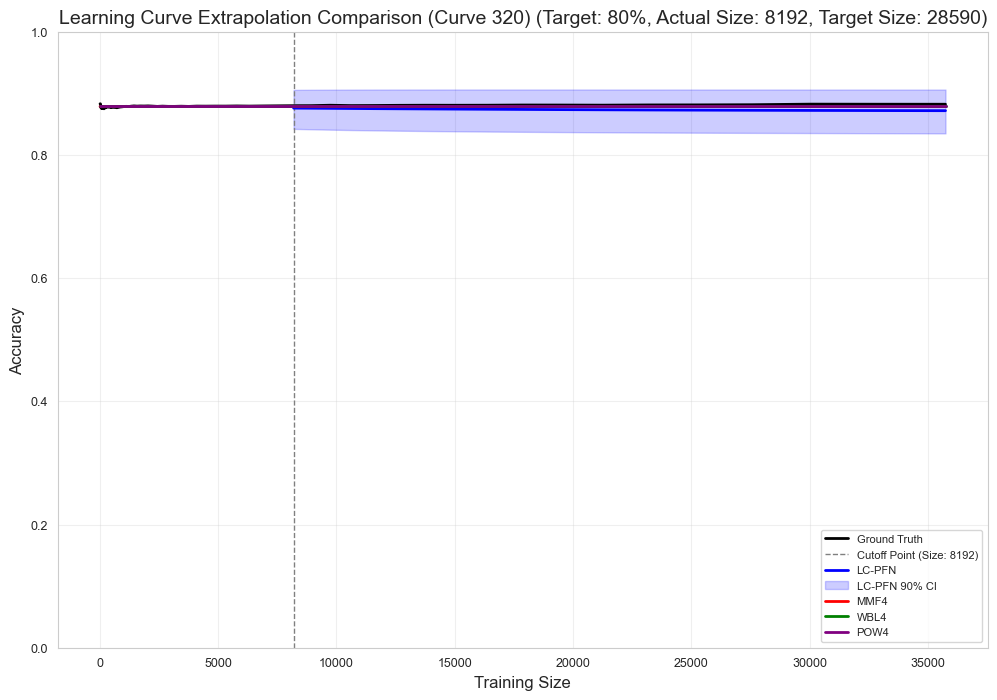

In [41]:
fig = compare_extrapolations(curve_idx=320, data=test_curves, anchor_sizes=ANCHOR_SIZE, lcpfn_model=model, cutoff_percentage=0.8)
plt.show()

## Performance Evaluation Metrics

In [42]:
def calculate_smape(y_true, y_pred):
    denominator = np.abs(y_true) + np.abs(y_pred)
    return 100 * np.mean(np.where(denominator == 0, 0, np.abs(y_pred - y_true) / denominator))

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [43]:
def evaluate_extrapolations_with_metadata(curve_idx, curve, dataset_idx, learner_idx, anchor_sizes,
                                        lcpfn_model, min_points=10, random_cutoff=True,
                                        fixed_cutoff_idx=None, cutoff_percentage=None):
    """
    Evaluate extrapolations of a learning curve using LC-PFN and parametric models,
    keeping track of dataset and learner metadata.

    Args:
        curve_idx: Index of the learning curve in the original data
        curve: The learning curve data
        dataset_idx: Index of the dataset this curve comes from
        learner_idx: Index of the learner this curve comes from
        anchor_sizes: Training sizes corresponding to the curve points
        lcpfn_model: Trained LC-PFN model
        min_points: Minimum number of points to use for fitting
        random_cutoff: If True, uses a random cutoff point
        fixed_cutoff_idx: If provided, uses this specific cutoff index instead of generating a random one
        cutoff_percentage: If provided, uses this percentage of the curve for training

    Returns:
        List of dictionaries with metrics and metadata for each model
    """

    curve_flat = curve.flatten()
    valid_mask = np.isfinite(curve_flat)
    curve_clean = curve_flat[valid_mask]

    if len(curve_clean) <= min_points:
        return []

    curve_anchor_sizes = anchor_sizes[:len(curve_clean)]

    if cutoff_percentage is not None:
        cutoff_idx = max(min_points, int(cutoff_percentage * len(curve_clean)))
        cutoff_idx = min(cutoff_idx, len(curve_clean) - 1)
    elif fixed_cutoff_idx is not None:
        cutoff_idx = fixed_cutoff_idx
    elif random_cutoff:
        cutoff_idx = random.randint(min_points, len(curve_clean) - 1)
    else:
        cutoff_idx = len(curve_clean) - 1

    # LC-PFN extrapolation
    x_train_pfn, y_train_pfn, x_test_pfn, y_test_pfn, pred_mean, _, _ = extrapolate_lcpfn(
        curve_clean, anchor_sizes, lcpfn_model, min_points=min_points,
        random_cutoff=False, fixed_cutoff_idx=cutoff_idx
    )

    results = []
    if x_train_pfn is not None:
        smape = calculate_smape(y_test_pfn, pred_mean)
        mae = calculate_mae(y_test_pfn, pred_mean)
        mse = calculate_mse(y_test_pfn, pred_mean)

        results.append({
            'Curve_idx': curve_idx,
            'Dataset_idx': dataset_idx,
            'Learner_idx': learner_idx,
            'Learner_name': LEARNER_ZOO[learner_idx],
            'Model': 'LC-PFN',
            'SMAPE': smape,
            'MAE': mae,
            'MSE': mse,
            'Cutoff_idx': cutoff_idx,
            'Cutoff_percentage': cutoff_percentage,
            'Train_points': len(x_train_pfn),
            'Test_points': len(y_test_pfn)
        })

    # Parametric model extrapolations
    for model_name in ["MMF4", "WBL4", "POW4"]:
        result = extrapolate_parametric(
            curve_clean, anchor_sizes, model_name, min_points=min_points,
            random_cutoff=False, fixed_cutoff_idx=cutoff_idx
        )

        if result[0] is not None:
            x_train, y_train, x_test, y_test, y_pred_full = result
            y_pred_test = y_pred_full[cutoff_idx:]

            smape = calculate_smape(y_test, y_pred_test)
            mae = calculate_mae(y_test, y_pred_test)
            mse = calculate_mse(y_test, y_pred_test)

            results.append({
                'Curve_idx': curve_idx,
                'Dataset_idx': dataset_idx,
                'Learner_idx': learner_idx,
                'Learner_name': LEARNER_ZOO[learner_idx],
                'Model': model_name,
                'SMAPE': smape,
                'MAE': mae,
                'MSE': mse,
                'Cutoff_idx': cutoff_idx,
                'Cutoff_percentage': cutoff_percentage,
                'Train_points': len(x_train),
                'Test_points': len(y_test)
            })

    return results

In [44]:
def evaluate_all_curves_with_metadata(curves, curve_lengths, dataset_indices, learner_indices,
                                    anchor_sizes, lcpfn_model, min_points=10,
                                    cutoff_percentages=None, sample_size=None):
    """
    Evaluate all curves once, keeping track of all metadata for later filtering.

    Args:
        curves: List of learning curves
        curve_lengths: List of curve lengths
        dataset_indices: List of dataset indices for each curve
        learner_indices: List of learner indices for each curve
        anchor_sizes: Training sizes corresponding to the curve points
        lcpfn_model: Trained LC-PFN model
        min_points: Minimum number of points to use for fitting
        cutoff_percentages: List of cutoff percentages to evaluate (if None, uses random cutoff)
        sample_size: If provided, randomly sample this many curves

    Returns:
        DataFrame with all evaluation results and metadata
    """

    if sample_size and len(curves) > sample_size:
        indices = random.sample(range(len(curves)), sample_size)
        curves = [curves[i] for i in indices]
        curve_lengths = [curve_lengths[i] for i in indices]
        dataset_indices = [dataset_indices[i] for i in indices]
        learner_indices = [learner_indices[i] for i in indices]

    all_results = []

    if cutoff_percentages:
        for cutoff_pct in cutoff_percentages:
            print(f"Evaluating with {cutoff_pct*100:.0f}% cutoff...")
            for i, curve in enumerate(tqdm(curves, desc=f"Cutoff {cutoff_pct*100:.0f}%")):
                results = evaluate_extrapolations_with_metadata(
                    curve_idx=i,
                    curve=curve,
                    dataset_idx=dataset_indices[i],
                    learner_idx=learner_indices[i],
                    anchor_sizes=anchor_sizes,
                    lcpfn_model=lcpfn_model,
                    min_points=min_points,
                    random_cutoff=False,
                    cutoff_percentage=cutoff_pct
                )
                all_results.extend(results)
    else:
        print("Evaluating with random cutoffs...")
        for i, curve in enumerate(tqdm(curves, desc="Processing curves")):
            results = evaluate_extrapolations_with_metadata(
                curve_idx=i,
                curve=curve,
                dataset_idx=dataset_indices[i],
                learner_idx=learner_indices[i],
                anchor_sizes=anchor_sizes,
                lcpfn_model=lcpfn_model,
                min_points=min_points,
                random_cutoff=True
            )
            all_results.extend(results)

    return pd.DataFrame(all_results)

In [45]:
def filter_results_by_learner_characteristic(results_df, characteristic_learner_indices,
                                           characteristic_name):
    """
    Filter evaluation results by learner characteristic.

    Args:
        results_df: DataFrame with evaluation results
        characteristic_learner_indices: List of learner indices for this characteristic
        characteristic_name: Name of the characteristic for labeling

    Returns:
        DataFrame filtered for the characteristic with added scenario column
    """
    filtered_df = results_df[results_df['Learner_idx'].isin(characteristic_learner_indices)].copy()
    filtered_df['Scenario'] = characteristic_name
    return filtered_df

In [46]:
def create_scenario_comparison_data(results_df):
    """
    Create comparison data for different learner characteristic scenarios.

    Args:
        results_df: DataFrame with all evaluation results

    Returns:
        DataFrame with scenario labels added
    """
    scenario_data = []

    scenarios = {
        'Flat': flat_learners_indices,
        'MonoConv': mono_conv_learners_indices,
        'Peaking': peaking_learner_indices,
        'Dipping': dipping_learner_indices
    }

    for scenario_name, learner_indices in scenarios.items():
        scenario_df = filter_results_by_learner_characteristic(
            results_df, learner_indices, scenario_name
        )
        scenario_data.append(scenario_df)

    return pd.concat(scenario_data, ignore_index=True)

sample_size = 200

In [47]:
file_path = Path(f'learning_curve_extrapolation_results_{sample_size}_samples_{model_name}.csv')
if file_path.exists():
    results_df = pd.read_csv(file_path)
else:
    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.manual_seed(SEED)
    results_df = evaluate_all_curves_with_metadata(
        curves=test_curves,
        curve_lengths=test_curve_lengths,
        dataset_indices=test_dataset_indices,
        learner_indices=test_learner_indices,
        anchor_sizes=ANCHOR_SIZE,
        lcpfn_model=model,
        min_points=25,
        cutoff_percentages=[0.1, 0.3, 0.5, 0.7, 0.9],
        sample_size=sample_size
    )

In [50]:
df = results_df
df['curve_idx'] = (df.index // 4) + 1
df['SMAPE_rank'] = df.groupby('curve_idx')['SMAPE'].rank(method='min')
df['MAE_rank'] = df.groupby('curve_idx')['MAE'].rank(method='min')
df['MSE_rank'] = df.groupby('curve_idx')['MSE'].rank(method='min')
df['Average_rank'] = df[['SMAPE_rank', 'MAE_rank', 'MSE_rank']].mean(axis=1)
df.to_csv(file_path, index=False)
results_df.to_csv(file_path)

print(f"\nTotal evaluations computed: {len(results_df)}")
print(f"Unique curves: {results_df['Curve_idx'].nunique()}")
print(f"Models: {list(results_df['Model'].unique())}")
print(f"Learner types: {list(results_df['Learner_name'].unique())}")


Total evaluations computed: 3880
Unique curves: 194
Models: ['LC-PFN', 'MMF4', 'WBL4', 'POW4']
Learner types: ['ExtraTree', 'KNN', 'ens.ExtraTrees', 'NearestCentroid', 'GaussianNB', 'RidgeClassifier', 'SGDClassifier', 'ens.GradientBoosting', 'SVC_rbf', 'PassiveAggressive', 'MLP', 'LogisticRegression', 'SVC_sigmoid', 'SVC_poly', 'Perceptron', 'BernoulliNB', 'MultinomialNB', 'ComplementNB', 'QDA', 'LDA', 'SVC_linear', 'Decision Tree', 'ens.RandomForest']


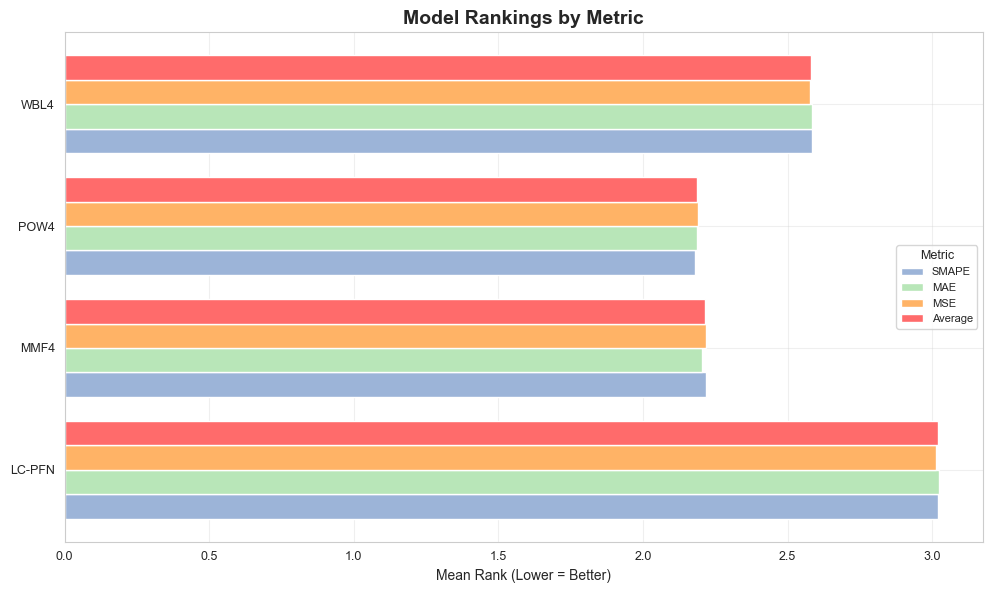

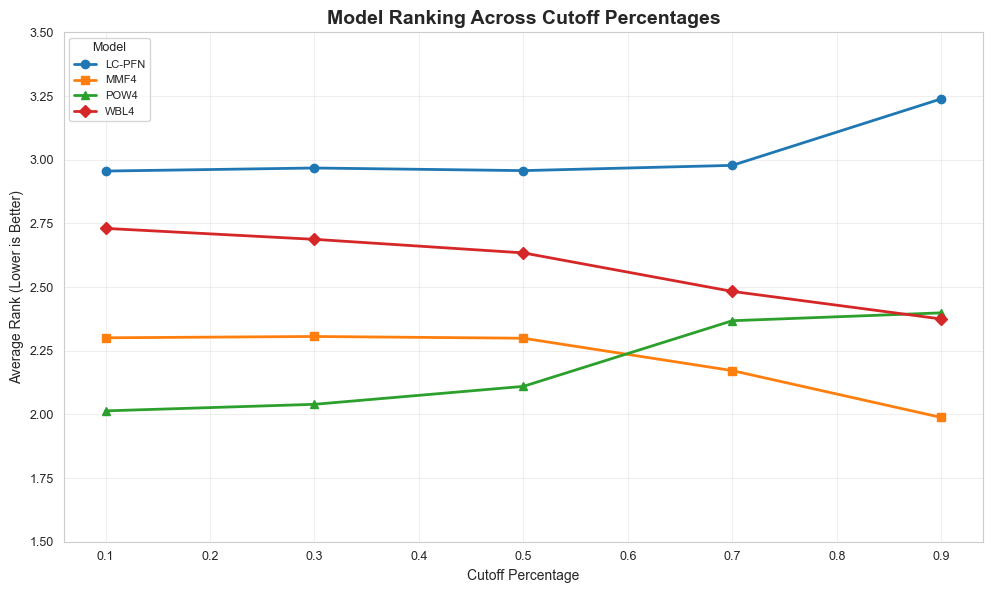

In [55]:
def plot_model_rankings_by_metric(df):

    avg_rankings = df.groupby('Model')[['SMAPE_rank', 'MAE_rank', 'MSE_rank', 'Average_rank']].mean()

    fig, ax = plt.subplots(figsize=(10, 6))

    colors = ['#9CB4D8', '#B8E6B8', '#FFB366', '#FF6B6B']

    x = np.arange(len(avg_rankings.index))
    width = 0.8

    bars1 = ax.barh(x - 0.3, avg_rankings['SMAPE_rank'], width/4, label='SMAPE', color=colors[0])
    bars2 = ax.barh(x - 0.1, avg_rankings['MAE_rank'], width/4, label='MAE', color=colors[1])
    bars3 = ax.barh(x + 0.1, avg_rankings['MSE_rank'], width/4, label='MSE', color=colors[2])
    bars4 = ax.barh(x + 0.3, avg_rankings['Average_rank'], width/4, label='Average', color=colors[3])

    ax.set_yticks(x)
    ax.set_yticklabels(avg_rankings.index)
    ax.set_xlabel('Mean Rank (Lower = Better)')
    ax.set_title('Model Rankings by Metric', fontsize=14, fontweight='bold')
    ax.legend(title='Metric', loc='center right')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

def plot_rankings_by_cutoff(df):

    cutoff_rankings = df.groupby(['Model', 'Cutoff_percentage'])['Average_rank'].mean().reset_index()

    fig, ax = plt.subplots(figsize=(10, 6))

    models = cutoff_rankings['Model'].unique()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    markers = ['o', 's', '^', 'D']

    for i, model in enumerate(models):
        model_data = cutoff_rankings[cutoff_rankings['Model'] == model]
        ax.plot(model_data['Cutoff_percentage'], model_data['Average_rank'],
                marker=markers[i], color=colors[i], label=model, linewidth=2, markersize=6)

    ax.set_xlabel('Cutoff Percentage')
    ax.set_ylabel('Average Rank (Lower is Better)')
    ax.set_title('Model Ranking Across Cutoff Percentages', fontsize=14, fontweight='bold')
    ax.legend(title='Model')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(1.5, 3.5)

    plt.tight_layout()
    return fig

fig1 = plot_model_rankings_by_metric(df)
fig2 = plot_rankings_by_cutoff(df)

In [59]:
scenario_df = create_scenario_comparison_data(results_df)
scenario_df.to_csv(Path('scenario_results.csv'))

In [112]:
def create_three_metric_boxplot(df, figsize=(16, 12)):

    plt.rcParams.update({
        'font.size': 14,
        'axes.labelsize': 14,
        'axes.titlesize': 14,
        'legend.fontsize': 14,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14
    })

    model_colors = {
        'MMF4': '#1f77b4',
        'WBL4': '#ff7f0e',
        'POW4': '#2ca02c',
        'LC-PFN': '#d62728'
    }

    metrics = ['SMAPE', 'MAE', 'MSE']
    metric_labels = {
        'SMAPE': 'SMAPE (%)',
        'MAE': 'MAE',
        'MSE': 'MSE'
    }

    fig, axes = plt.subplots(3, 1, figsize=figsize, facecolor='white')
    fig.suptitle('Model Performance Across All Metrics and Shapes',
                 fontsize=18, fontweight='bold', y=0.95)

    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        ax = axes[idx]

        sns.boxplot(data=df, x='Scenario', y=metric, hue='Model',
                   ax=ax, palette=model_colors, showfliers=False,
                   boxprops=dict(alpha=0.8), linewidth=1.2,
                   whiskerprops=dict(linewidth=1),
                   capprops=dict(linewidth=1))

        ax.set_title(f'{metric} Performance', fontweight='bold', fontsize=19)
        ax.set_xlabel('Shape', fontsize=17)
        ax.set_ylabel(metric_labels[metric], fontsize=18)
        ax.grid(True, alpha=0.2, axis='y')

        if idx == 1:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left',
                     fontsize=14, frameon=True, fancybox=True, shadow=True)
        else:
            ax.legend().remove()

    plt.tight_layout()
    plt.subplots_adjust(top=0.88, right=0.85)

    return fig

def create_metric_comparison_by_cutoff(df, metrics=['SMAPE', 'MAE', 'MSE'], figsize=(16, 12)):

    model_colors = {
        'MMF4': '#1f77b4',
        'WBL4': '#ff7f0e',
        'POW4': '#2ca02c',
        'LC-PFN': '#d62728'
    }

    n_metrics = len(metrics)
    fig, axes = plt.subplots(n_metrics, 1, figsize=figsize, facecolor='white')

    if n_metrics == 1:
        axes = [axes]

    fig.suptitle('Model Performance Across Cutoff Percentages by Metric',
                 fontsize=14, fontweight='bold', y=0.95)

    for idx, metric in enumerate(metrics):
        ax = axes[idx]

        sns.boxplot(data=df, x='Cutoff_percentage', y=metric, hue='Model',
                   ax=ax, palette=model_colors, showfliers=False,
                   boxprops=dict(alpha=0.8), linewidth=1.2)

        ax.set_title(f'{metric} Performance by Cutoff Percentage', fontweight='bold')
        ax.set_xlabel('Cutoff Percentage')
        ax.set_ylabel(metric)
        ax.grid(True, alpha=0.2, axis='y')

        cutoff_labels = [f'{int(float(label.get_text())*100)}%' for label in ax.get_xticklabels()]
        ax.set_xticklabels(cutoff_labels)

        if idx == 0:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left',
                     fontsize=8, frameon=True)
        else:
            ax.legend().remove()

    plt.tight_layout()
    plt.subplots_adjust(top=0.88, right=0.85)

    return fig

Performing statistical analysis...
Summary of significant differences (p < 0.05):

SMAPE: 11 significant comparisons out of 120

MAE: 15 significant comparisons out of 120

MSE: 9 significant comparisons out of 120


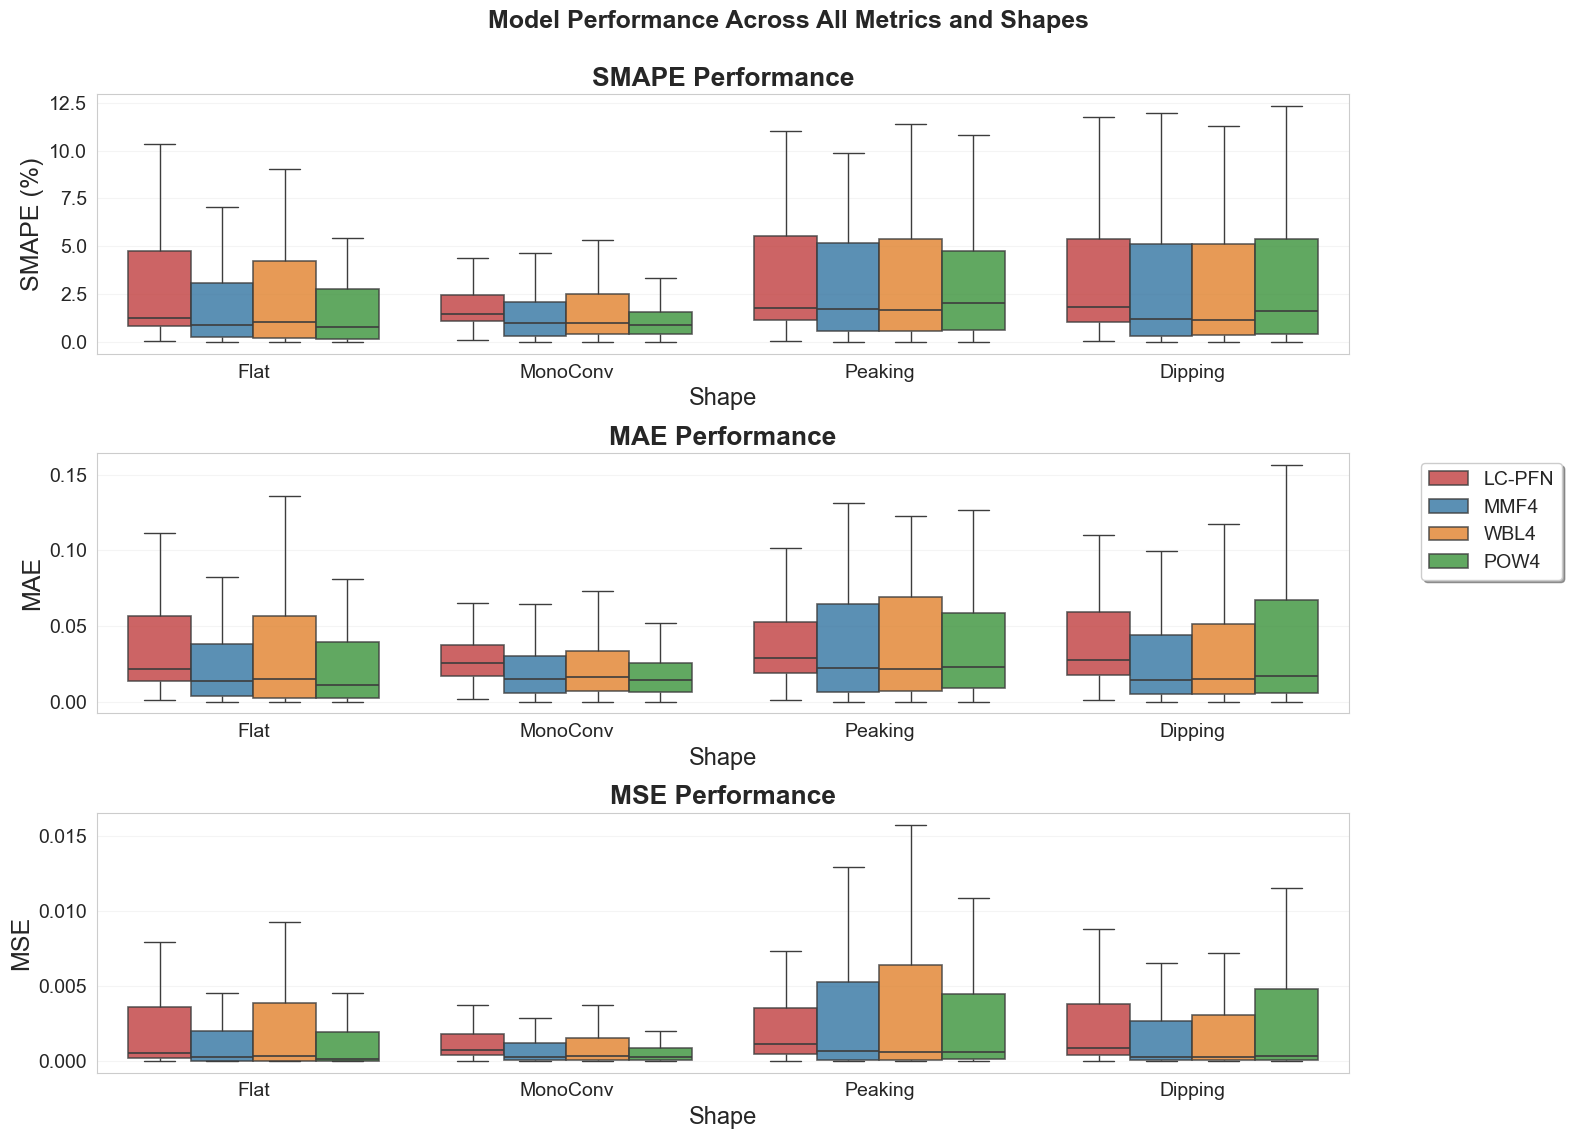

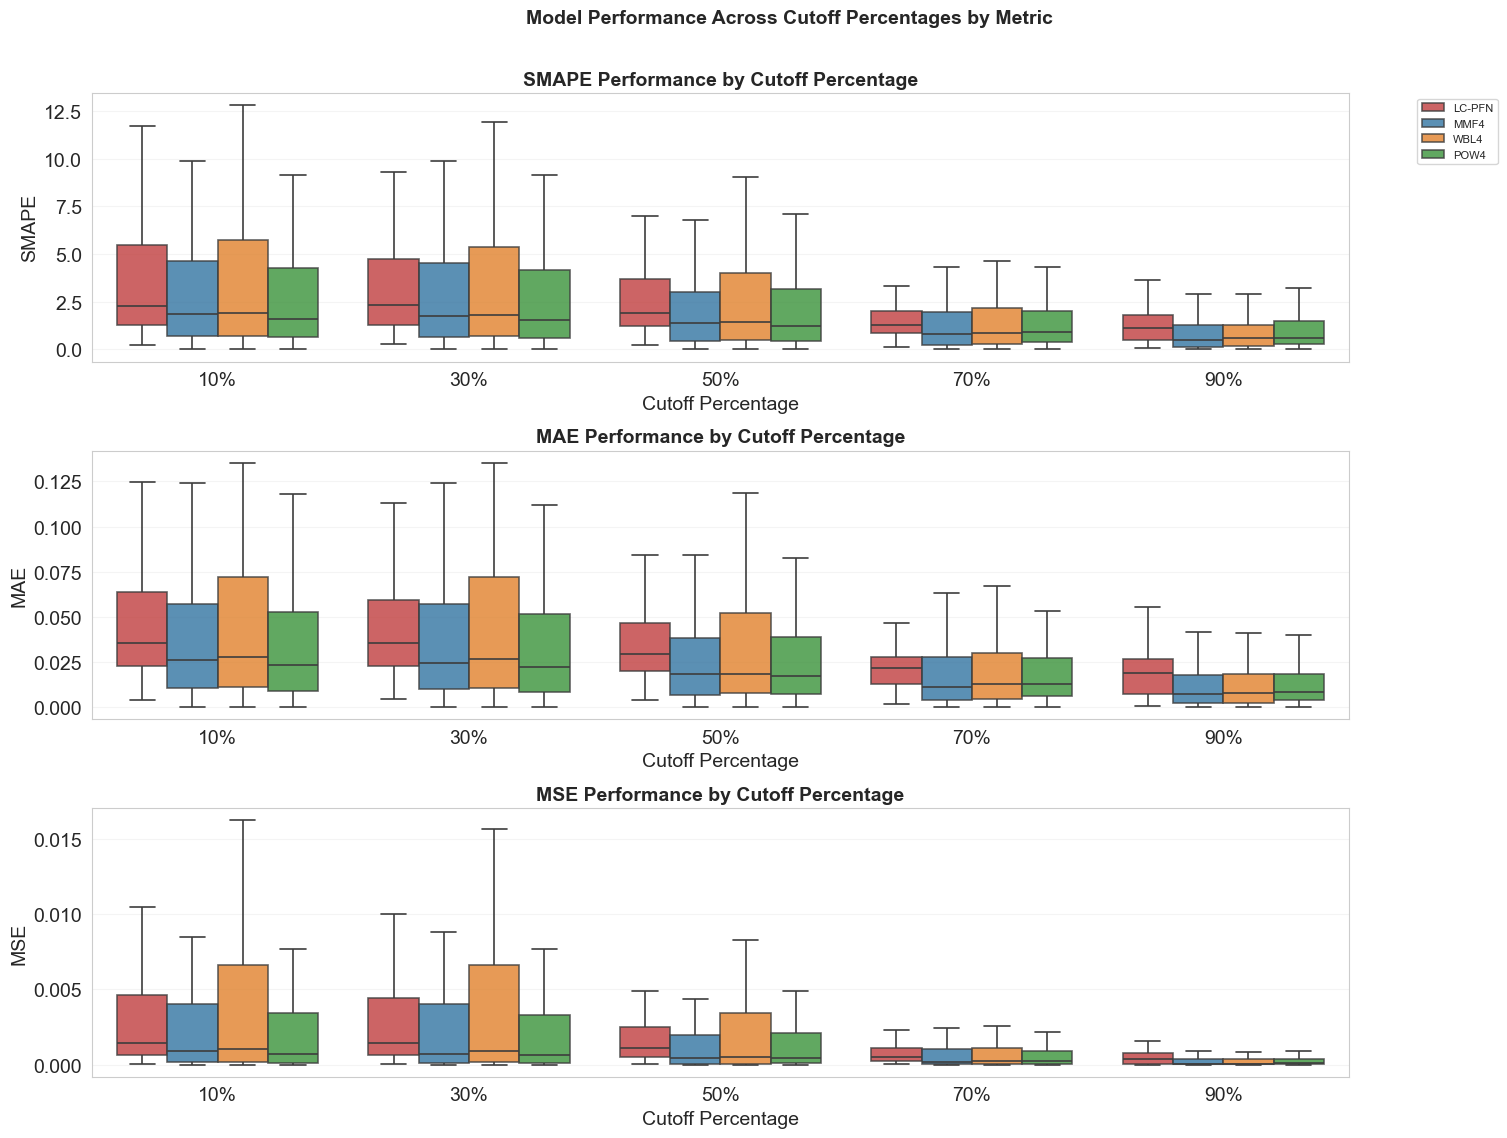

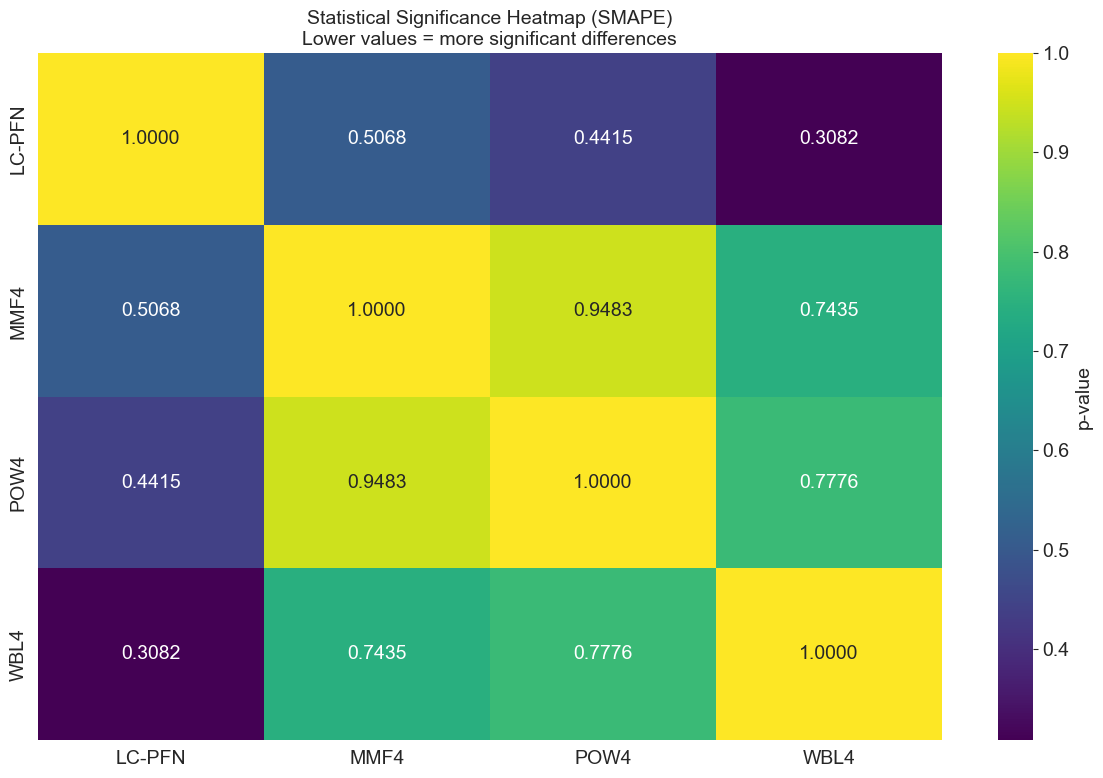

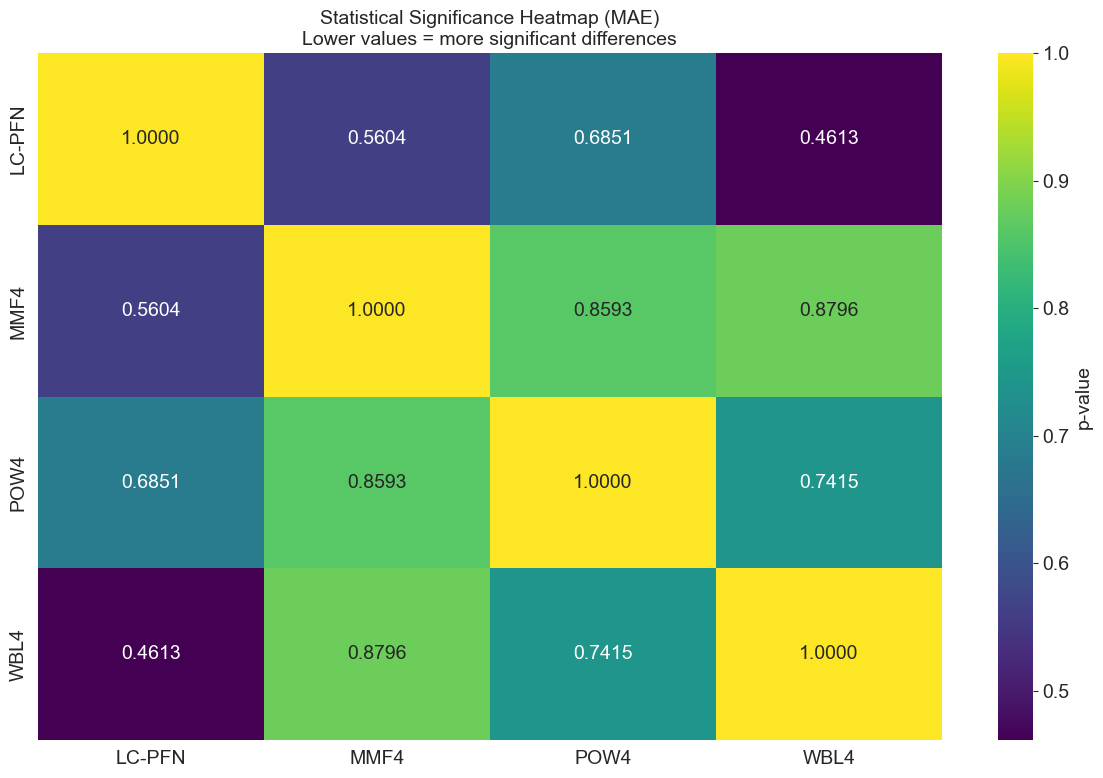

In [114]:
fig_four_metrics = create_three_metric_boxplot(scenario_df, figsize=(16, 12))
plt.savefig('../visuals - experiment 2/shape.png')
plt.show()

fig_cutoff_comparison = create_metric_comparison_by_cutoff(scenario_df, figsize=(16, 12))
plt.savefig('../visuals - experiment 2/cutoff.png')
plt.show()

In [63]:
def create_compact_shape_cutoff_boxplots(df, metric='SMAPE', figsize=(12, 4)):

    plt.rcParams.update({
        'font.size': 9,
        'axes.labelsize': 10,
        'axes.titlesize': 11,
        'legend.fontsize': 8
    })

    model_colors = {
        'MMF4': '#1f77b4',
        'WBL4': '#ff7f0e',
        'POW4': '#2ca02c',
        'LC-PFN': '#d62728'
    }

    scenarios = {
        'Flat': flat_learners_indices,
        'MonoConv': mono_conv_learners_indices,
        'Peaking': peaking_learner_indices,
        'Dipping': dipping_learner_indices
    }

    fig, axes = plt.subplots(1, 4, figsize=figsize, facecolor='white', sharey=True)
    fig.suptitle(f'{metric} Performance Across LC Shapes and Cutoff Percentages',
                 fontsize=12, fontweight='bold', y=0.95)

    for idx, scenario in enumerate(scenarios):
        ax = axes[idx]
        scenario_data = df[df['Scenario'] == scenario]

        sns.boxplot(data=scenario_data, x='Cutoff_percentage', y=metric,
                   hue='Model', ax=ax, palette=model_colors,
                   showfliers=False, linewidth=1,
                   boxprops=dict(alpha=0.8),
                   whiskerprops=dict(linewidth=0.8),
                   capprops=dict(linewidth=0.8))

        ax.set_title(scenario, fontweight='bold', fontsize=10)
        ax.set_xlabel('Cutoff %', fontsize=9)
        ax.set_ylabel(f'{metric} (%)' if metric == 'SMAPE' and idx == 0 else
                     f'{metric}' if metric == 'MASE' and idx == 0 else '', fontsize=9)

        cutoff_labels = [f'{int(float(label.get_text())*100)}%' for label in ax.get_xticklabels()]
        ax.set_xticklabels(cutoff_labels, rotation=45)

        ax.grid(True, alpha=0.2, axis='y')

        if idx == 3:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left',
                     fontsize=7, frameon=True)
        else:
            ax.legend().remove()

    plt.tight_layout()
    plt.subplots_adjust(top=0.85, right=0.88)

    return fig

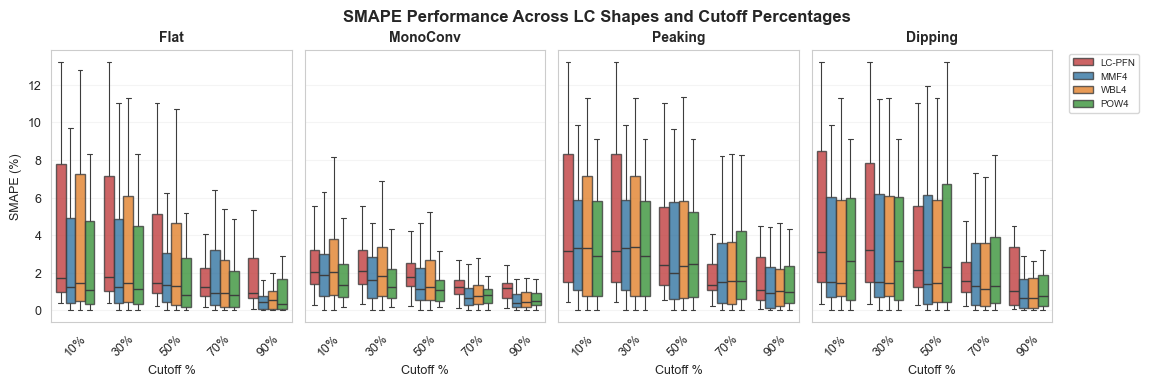

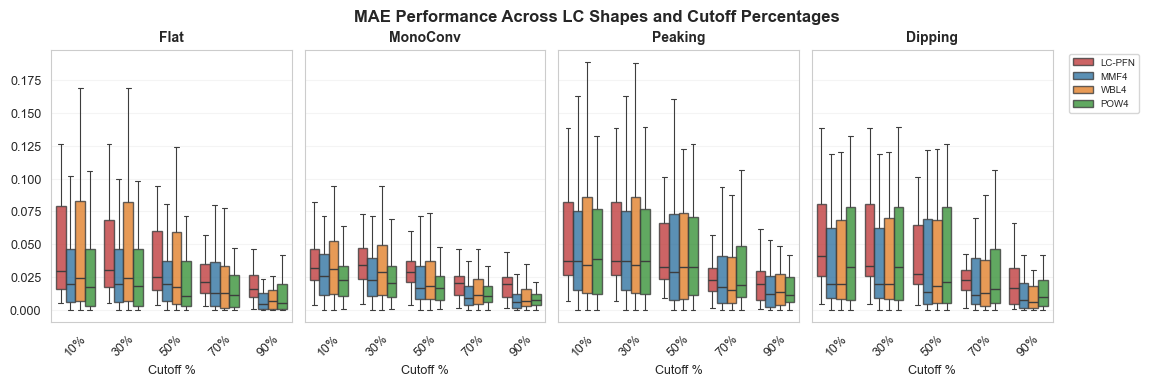

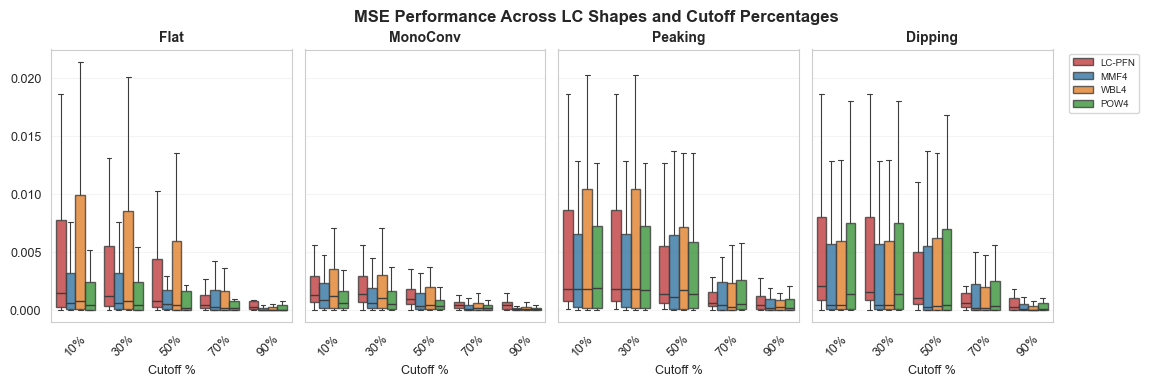

In [64]:
fig = create_compact_shape_cutoff_boxplots(scenario_df, metric='SMAPE', figsize=(12, 4))
plt.savefig('../visuals - experiment 2/shape_cutoff_smape.png')
plt.show()

fig = create_compact_shape_cutoff_boxplots(scenario_df, metric='MAE', figsize=(12, 4))
plt.savefig('../visuals - experiment 2/shape_cutoff_mae.png')
plt.show()

fig = create_compact_shape_cutoff_boxplots(scenario_df, metric='MSE', figsize=(12, 4))
plt.savefig('../visuals - experiment 2/shape_cutoff_mse.png')
plt.show()

Creating binary scenario comparison data...
Binary scenario breakdown:
Model                                  LC-PFN  MMF4  POW4  WBL4
Binary_Scenario          Group                                 
Dipping vs Non-Dipping   Dipping          215   215   215   215
                         Non-Dipping      755   755   755   755
Flat vs Non-Flat         Flat             180   180   180   180
                         Non-Flat         790   790   790   790
MonoConv vs Non-MonoConv MonoConv         455   455   455   455
                         Non-MonoConv     515   515   515   515
Peaking vs Non-Peaking   Non-Peaking      740   740   740   740
                         Peaking          230   230   230   230
Creating binary comparison visualizations...


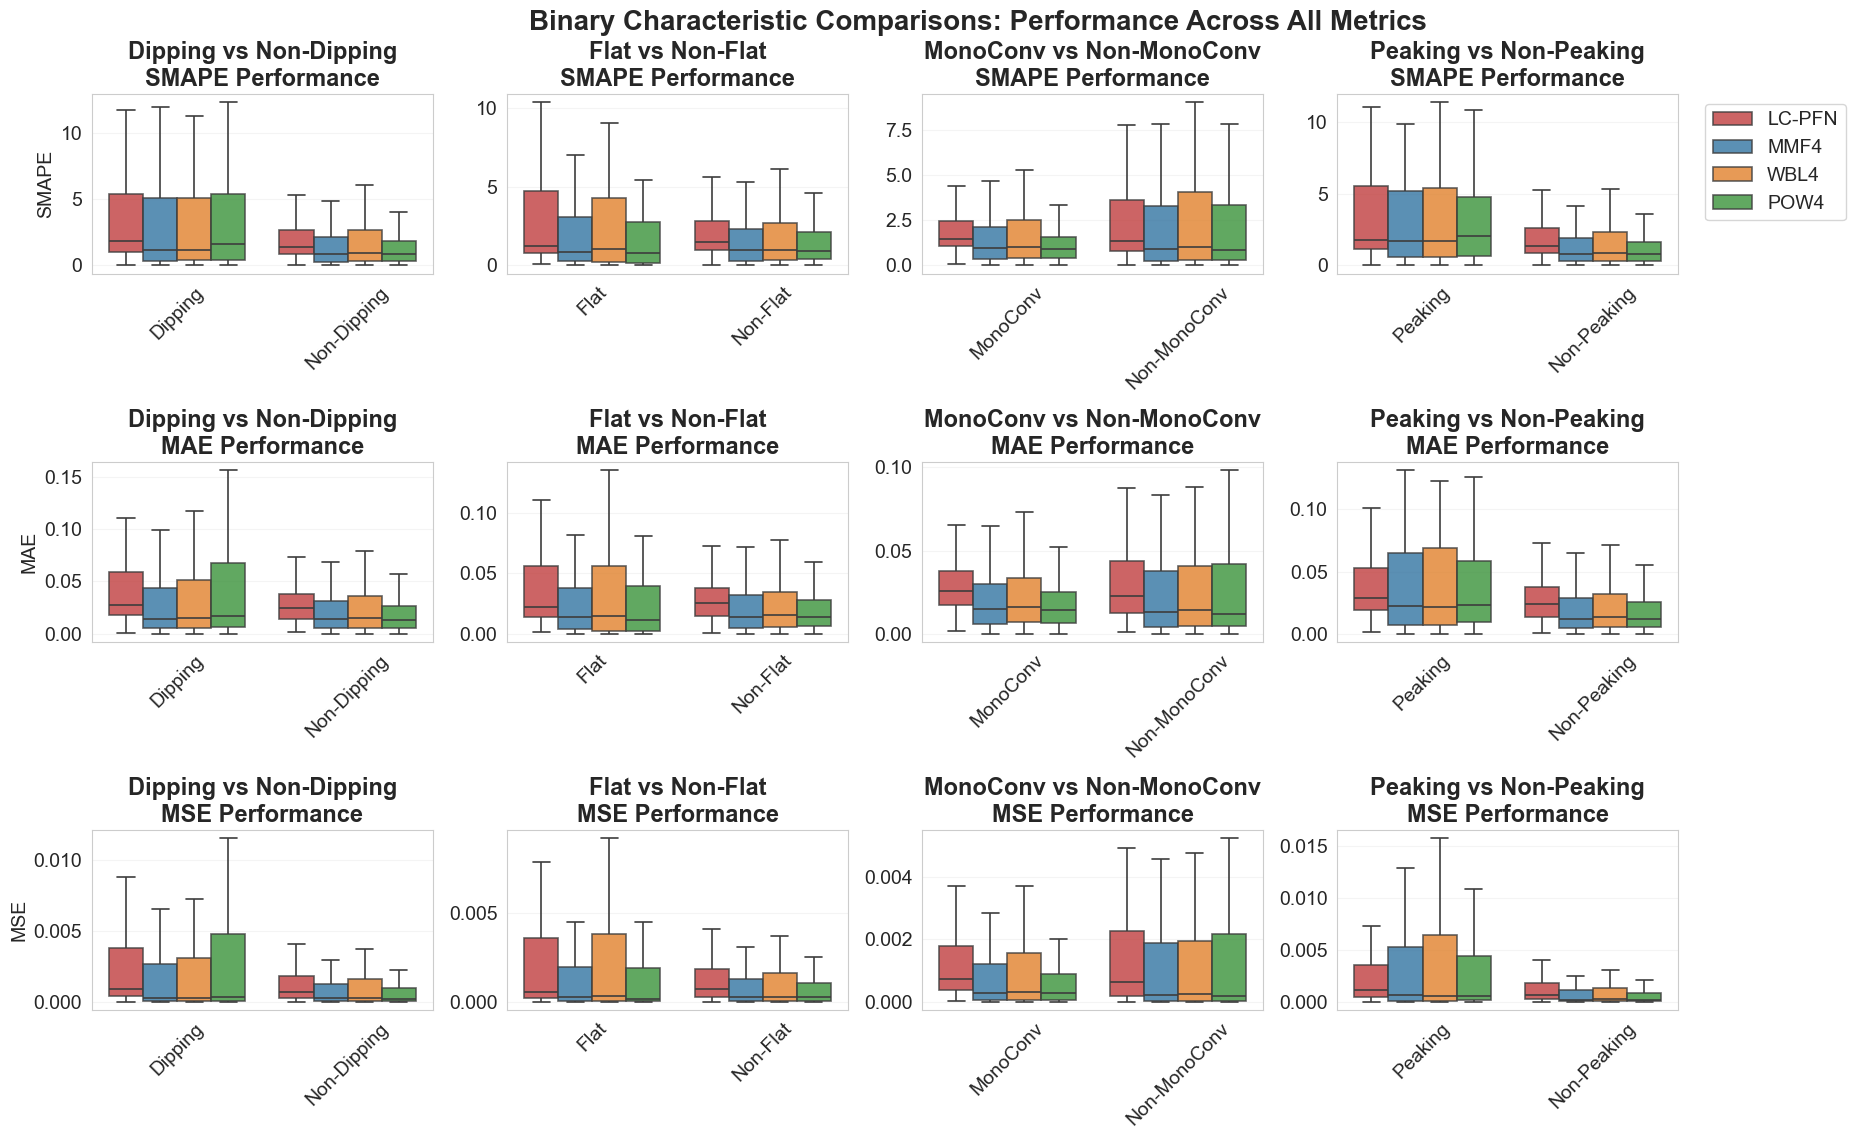

Performing binary statistical tests...

Summary of binary comparisons (SMAPE):
                    Scenario   Model Better_Group   Worse_Group  \
0           Flat vs Non-Flat  LC-PFN     Non-Flat          Flat   
1           Flat vs Non-Flat    MMF4     Non-Flat          Flat   
2           Flat vs Non-Flat    WBL4     Non-Flat          Flat   
3           Flat vs Non-Flat    POW4     Non-Flat          Flat   
4   MonoConv vs Non-MonoConv  LC-PFN     MonoConv  Non-MonoConv   
5   MonoConv vs Non-MonoConv    MMF4     MonoConv  Non-MonoConv   
6   MonoConv vs Non-MonoConv    WBL4     MonoConv  Non-MonoConv   
7   MonoConv vs Non-MonoConv    POW4     MonoConv  Non-MonoConv   
8     Peaking vs Non-Peaking  LC-PFN  Non-Peaking       Peaking   
9     Peaking vs Non-Peaking    MMF4  Non-Peaking       Peaking   
10    Peaking vs Non-Peaking    WBL4  Non-Peaking       Peaking   
11    Peaking vs Non-Peaking    POW4  Non-Peaking       Peaking   
12    Dipping vs Non-Dipping  LC-PFN  Non-Dipping 

In [117]:
def create_binary_scenario_comparison_data(results_df):

    binary_scenario_data = []

    binary_scenarios = {
        'Flat vs Non-Flat': {
            'characteristic': flat_learners_indices,
            'non_characteristic': [i for i in range(23) if i not in flat_learners_indices]
        },
        'MonoConv vs Non-MonoConv': {
            'characteristic': mono_conv_learners_indices,
            'non_characteristic': [i for i in range(23) if i not in mono_conv_learners_indices]
        },
        'Peaking vs Non-Peaking': {
            'characteristic': peaking_learner_indices,
            'non_characteristic': [i for i in range(23) if i not in peaking_learner_indices]
        },
        'Dipping vs Non-Dipping': {
            'characteristic': dipping_learner_indices,
            'non_characteristic': [i for i in range(23) if i not in dipping_learner_indices]
        }
    }

    for comparison_name, indices_dict in binary_scenarios.items():
        # Characteristic group
        char_df = results_df[results_df['Learner_idx'].isin(indices_dict['characteristic'])].copy()
        char_df['Binary_Scenario'] = comparison_name
        char_df['Group'] = comparison_name.split(' vs ')[0]  # e.g., 'Flat'

        # Non-characteristic group
        non_char_df = results_df[results_df['Learner_idx'].isin(indices_dict['non_characteristic'])].copy()
        non_char_df['Binary_Scenario'] = comparison_name
        non_char_df['Group'] = comparison_name.split(' vs ')[1]  # e.g., 'Non-Flat'

        binary_scenario_data.extend([char_df, non_char_df])

    return pd.concat(binary_scenario_data, ignore_index=True)

def create_binary_comparison_boxplot(df, metrics=['SMAPE', 'MAE', 'MSE'], figsize=(20, 12)):

    plt.rcParams.update({
        #'font.size': 14,
        'axes.labelsize': 14,
        #'axes.titlesize': 14,
        #'legend.fontsize': 14,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14
    })
    model_colors = {
        'MMF4': '#1f77b4',
        'WBL4': '#ff7f0e',
        'POW4': '#2ca02c',
        'LC-PFN': '#d62728'
    }

    n_metrics = len(metrics)
    n_scenarios = df['Binary_Scenario'].nunique()

    fig, axes = plt.subplots(n_metrics, n_scenarios, figsize=figsize, facecolor='white')

    if n_metrics == 1:
        axes = axes.reshape(1, -1)
    if n_scenarios == 1:
        axes = axes.reshape(-1, 1)

    fig.suptitle('Binary Characteristic Comparisons: Performance Across All Metrics',
                 fontsize=20, fontweight='bold', y=0.95)

    scenarios = sorted(df['Binary_Scenario'].unique())

    for metric_idx, metric in enumerate(metrics):
        for scenario_idx, scenario in enumerate(scenarios):
            ax = axes[metric_idx, scenario_idx]

            scenario_data = df[df['Binary_Scenario'] == scenario]

            sns.boxplot(data=scenario_data, x='Group', y=metric, hue='Model',
                       ax=ax, palette=model_colors, showfliers=False,
                       boxprops=dict(alpha=0.8), linewidth=1.2)

            ax.set_title(f'{scenario}\n{metric} Performance', fontweight='bold', fontsize=17)
            ax.set_xlabel('')
            ax.set_ylabel(metric if scenario_idx == 0 else '')
            ax.grid(True, alpha=0.2, axis='y')

            ax.tick_params(axis='x', rotation=45)

            if metric_idx == 0 and scenario_idx == n_scenarios - 1:
                handles, labels = ax.get_legend_handles_labels()
                ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left',
                         fontsize=14, frameon=True)
            else:
                ax.legend().remove()

    plt.tight_layout()
    plt.subplots_adjust(top=0.88, right=0.85)

    return fig

print("Creating binary scenario comparison data...")
binary_scenario_df = create_binary_scenario_comparison_data(results_df)

print(f"Binary scenario breakdown:")
print(binary_scenario_df.groupby(['Binary_Scenario', 'Group', 'Model']).size().unstack(fill_value=0))

print("Creating binary comparison visualizations...")
fig_binary_comparison = create_binary_comparison_boxplot(binary_scenario_df, figsize=(20, 12))
plt.savefig('../visuals - experiment 2/binary_comparison.png')
plt.show()

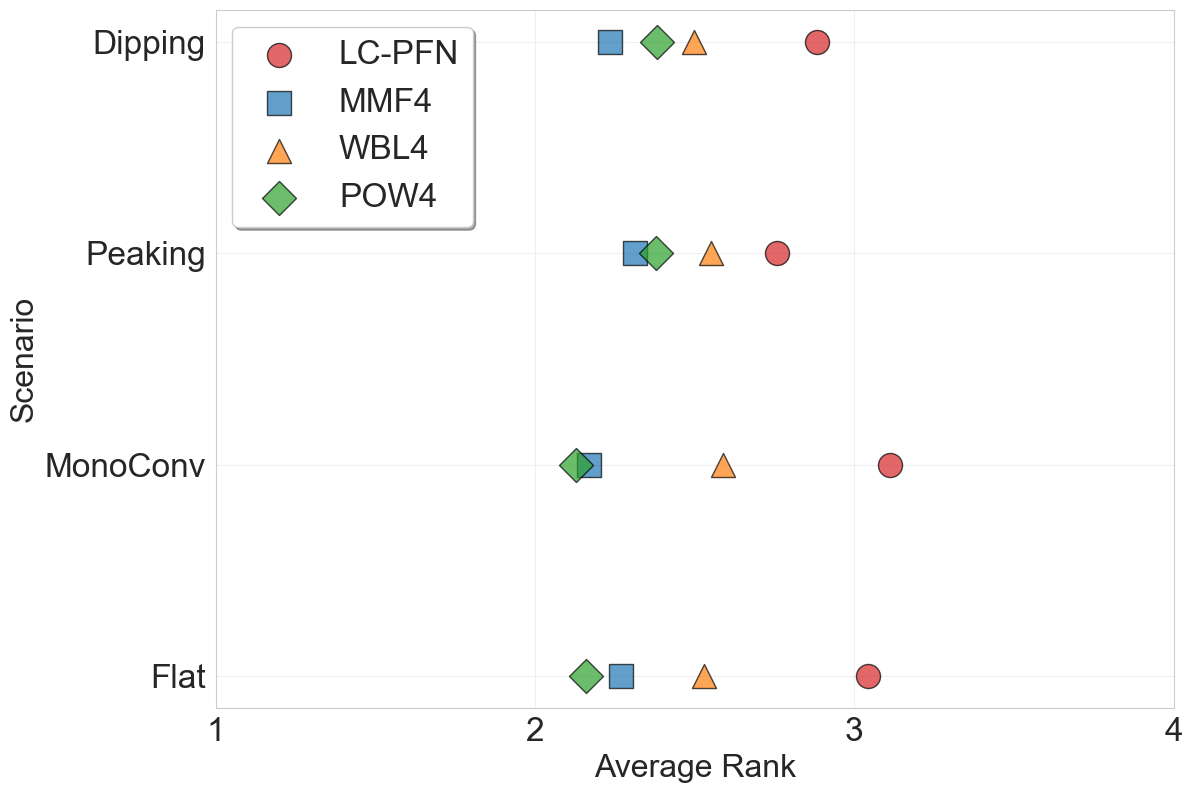

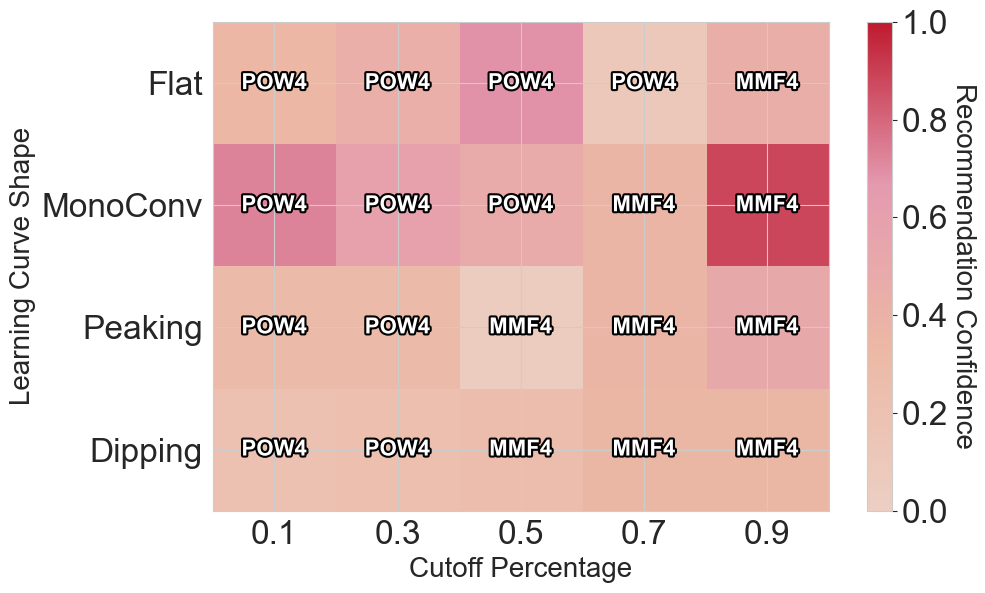

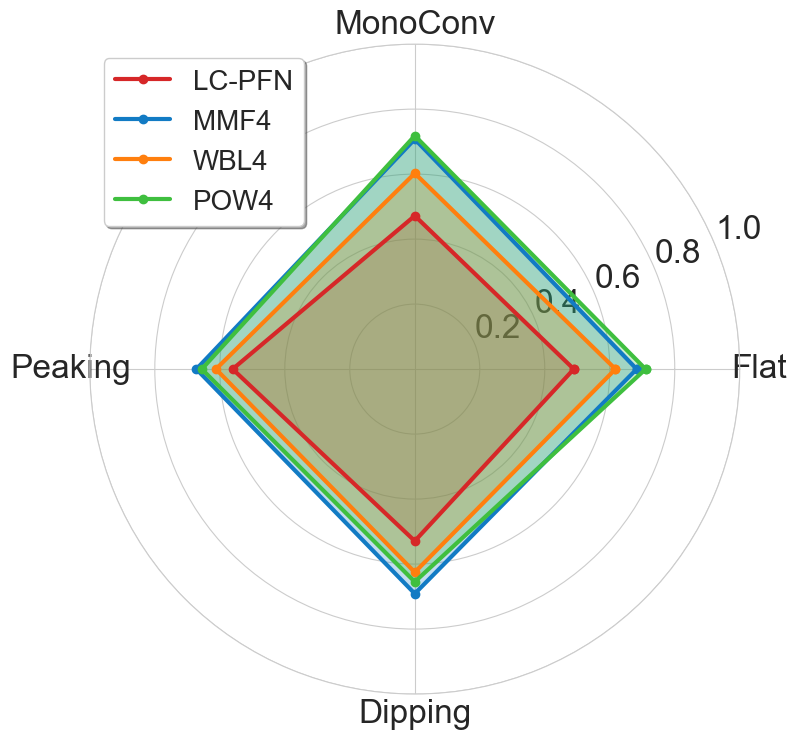

In [102]:
scenario_results = scenario_df
def plot_shape_performance_scatter(scenario_results):

    fig, ax = plt.subplots(figsize=(12, 8))
    plt.rcParams.update({
        'xtick.labelsize': 24,
        'ytick.labelsize': 24
    })

    model_styles = {
        'LC-PFN': {'color': '#d62728', 'marker': 'o', 'size': 300},
        'MMF4': {'color': '#1f77b4', 'marker': 's', 'size': 300},
        'WBL4': {'color': '#ff7f0e', 'marker': '^', 'size': 300},
        'POW4': {'color': '#2ca02c', 'marker': 'D', 'size': 300}
    }

    shapes = scenario_results['Scenario'].unique()
    shape_positions = {shape: i for i, shape in enumerate(shapes)}

    for model in scenario_results['Model'].unique():
        model_data = scenario_results[scenario_results['Model'] == model]

        shape_avg_ranks = model_data.groupby('Scenario')['Average_rank'].mean()

        y_positions = [shape_positions[shape] for shape in shape_avg_ranks.index]

        ax.scatter(shape_avg_ranks.values, y_positions,
                  color=model_styles[model]['color'],
                  marker=model_styles[model]['marker'],
                  s=model_styles[model]['size'],
                  label=model,
                  alpha=0.7,
                  edgecolors='black',
                  linewidth=1)

    ax.set_yticks(range(len(shapes)))
    ax.set_yticklabels(shapes)
    ax.set_xlim(1.0, 4.0)
    ax.set_xticks([1, 2, 3, 4])
    ax.set_xlabel('Average Rank', fontsize=23)
    ax.set_ylabel('Scenario', fontsize=23)
    ax.set_title('', fontsize=14, fontweight='bold')  #Model Performance by Learning Curve Shape
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(0, 1), loc='upper left', frameon=True, fancybox=True, shadow=True, fontsize=24)

    plt.tight_layout()
    return fig

def plot_recommendation_matrix(scenario_results):

    plt.rcParams.update({
        'xtick.labelsize': 24,
        'ytick.labelsize': 24
    })
    pivot_data = []
    confidence_data = []

    shapes = scenario_results['Scenario'].unique()
    cutoffs = sorted(scenario_results['Cutoff_percentage'].unique())

    for shape in shapes:
        shape_row = []
        confidence_row = []

        for cutoff in cutoffs:
            subset = scenario_results[
                (scenario_results['Scenario'] == shape) &
                (scenario_results['Cutoff_percentage'] == cutoff)
            ]

            if not subset.empty:
                model_performance = subset.groupby('Model')['Average_rank'].mean().sort_values()
                best_model = model_performance.index[0]
                best_rank = model_performance.iloc[0]

                if len(model_performance) > 1:
                    second_best_rank = model_performance.iloc[1]
                    rank_diff = second_best_rank - best_rank
                    confidence = min(1.0, rank_diff / 0.5)  # Scale so 0.5 rank difference = full confidence
                else:
                    confidence = 1.0

                shape_row.append(best_model)
                confidence_row.append(confidence)
            else:
                shape_row.append('N/A')
                confidence_row.append(0)

        pivot_data.append(shape_row)
        confidence_data.append(confidence_row)

    fig, ax = plt.subplots(figsize=(10, 6))

    conf_matrix = np.array(confidence_data)

    im = ax.imshow(conf_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

    for i in range(len(shapes)):
        for j in range(len(cutoffs)):
            text = pivot_data[i][j]
            txt = ax.text(j, i, text, ha='center', va='center', color='white', fontweight='bold', fontsize=16)
            txt.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])

    ax.set_xticks(range(len(cutoffs)))
    ax.set_xticklabels([c for c in cutoffs])
    ax.set_yticks(range(len(shapes)))
    ax.set_yticklabels(shapes)
    ax.set_xlabel('Cutoff Percentage', fontsize=20)
    ax.set_ylabel('Learning Curve Shape', fontsize=20)
    ax.set_title('', fontsize=14, fontweight='bold')  # Model Recommendation Matrix\n(Color intensity = Recommendation confidence)

    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ['#ECCFC3', '#ECB8A5', '#E49AB0', '#BF1A2F'])
    im = ax.imshow(conf_matrix, cmap=custom_cmap, aspect='auto', vmin=0, vmax=1)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Recommendation Confidence', rotation=270, labelpad=20, fontsize=20)

    plt.tight_layout()
    return fig

def plot_strength_radar(scenario_results):

    plt.rcParams.update({
        'xtick.labelsize': 24,
        'ytick.labelsize': 24
    })
    models = scenario_results['Model'].unique()
    shapes = scenario_results['Scenario'].unique()

    num_vars = len(shapes)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    colors = ['#d62728', '#127bc4', '#ff7f0e', '#3fbf3f']

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    max_rank = scenario_results['Average_rank'].max()

    for idx, model in enumerate(models):
        model_data = scenario_results[scenario_results['Model'] == model]
        shape_performance = model_data.groupby('Scenario')['Average_rank'].mean()

        scores = []
        for shape in shapes:
            if shape in shape_performance.index:
                score = (max_rank - shape_performance[shape] + 1) / max_rank
            else:
                score = 0
            scores.append(score)
        scores += scores[:1]

        ax.plot(angles, scores, 'o-', linewidth=3, label=model, color=colors[idx])
        ax.fill(angles, scores, alpha=0.25, color=colors[idx])

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(shapes)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=24)
    ax.set_ylim(0, 1)
    ax.set_title('', size=16, fontweight='bold', pad=20)  # Model Strength Profiles Across Learning Curve Shapes

    ax.grid(True)
    ax.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=True, fancybox=True, shadow=True, fontsize=20)
    plt.tight_layout()
    return fig

fig1 = plot_shape_performance_scatter(scenario_results)
plt.savefig('../visuals - experiment 2/rank_shape.png')
fig2 = plot_recommendation_matrix(scenario_results)
plt.savefig('../visuals - experiment 2/recommendation_matrix.png')
fig3 = plot_strength_radar(scenario_results)
plt.savefig('../visuals - experiment 2/spider_plot_shape.png')